In [1]:
import sys, os
import glob
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.layers.core import Activation
from keras import backend as K
from keras.optimizers import RMSprop
from keras.layers.pooling import AveragePooling1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.core import Dropout
from keras.models import load_model
import keras
from keras.layers import Input
from sklearn.metrics import mean_squared_error
from keras.layers.normalization import BatchNormalization
from opts import parse_opts_offline
from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

Using Theano backend.


In [2]:
# Standardization
def standardize(x):
    return (x - np.mean(x)) / np.std(x)

# RMSE
def RMSE(x, y):
    return np.sqrt(np.sum((x - y)**2)/len(x))

# Standardized RMSE
def norm_rmse(x, y):
    x_norm = (x - np.mean(x))/np.std(x)
    y_norm = (y - np.mean(y))/np.std(y)
    return np.sqrt(np.sum((x_norm - y_norm)**2)/len(x))

In [3]:
# Reshapes data for LSTM given the number of timesteps and number of predictions
# current LSTM model predicts 25 steps ahead given 100 historical timesteps
def to_XY(data, n_steps = 100, n_predict = 25, standardized = False):
    X, Y = [], []
    for i in range(len(data) - n_steps + 1 - n_predict):
        if standardized:
            X.append(standardize(np.array(data[i : i + n_steps, :])))
            Y.append(standardize(np.array(data[i + n_steps: i + n_steps + n_predict, :])))
        else: 
            X.append(np.array(data[i : i + n_steps, :]))
            Y.append(np.array(data[i + n_steps: i + n_steps + n_predict, :]))
    return np.array(X), np.array(Y)

In [4]:
# Loading the model
model = load_model('model/LTE_880M.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 64)           49408     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 64)           256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 64)           33024     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 64)           256       
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 3200)             

In [4]:
# Reading the availabel data
LTE880 = np.loadtxt('data/LTE_880M_normal.txt')
LTE729 = np.loadtxt('data/LTE_729M_normal.txt')

In [5]:
# Plot outliers
def plot_spectrum(spectrum, title = ''):
    fig, ax = plt.subplots(figsize = (12, 5))

    ax.set_ylabel('signal', fontsize = 15)
#     ax.set_xlabel('sample # from ' + title, fontsize = 15)
   
    plt.plot(spectrum, color = 'royalblue', label = title)
    plt.grid()
    plt.legend(fontsize = 16, loc = 'upper right')
    plt.tight_layout()
    plt.savefig(title + '.png', dpi = 125)

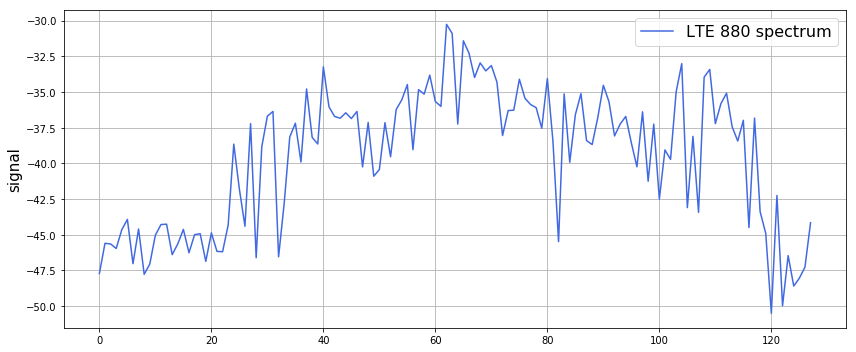

In [6]:
plot_spectrum(LTE880[0], 'LTE 880 spectrum')

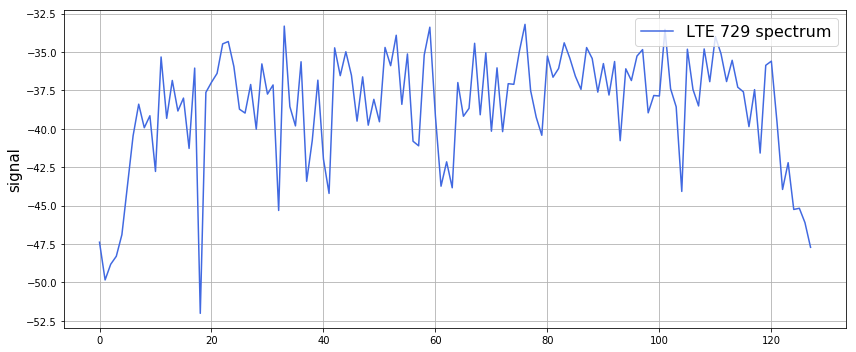

In [7]:
plot_spectrum(LTE729[0], 'LTE 729 spectrum')

In [6]:
# Reshaping the data for LSTM
# with standardization: mean => 0, std =>1
LTE880_X, LTE880_Y = to_XY(LTE880, 100, 25, True)
LTE729_X, LTE729_Y = to_XY(LTE729, 100, 25, True)

In [7]:
print (LTE880_X.shape, LTE729_X.shape)
print (LTE880_Y.shape, LTE729_Y.shape)

(24900, 100, 128) (24900, 100, 128)
(24900, 25, 128) (24900, 25, 128)


In [8]:
# Generating predictions with LSTM
LTE880_predictions = model.predict(LTE880_X)
LTE729_predictions = model.predict(LTE729_X)

In [9]:
# Reshaping the original data for easier calculation of RMSE
LTE880_Y = np.reshape(LTE880_Y, (24900, 3200))
LTE729_Y = np.reshape(LTE729_Y, (24900, 3200))
# LTE880_predictions = np.reshape(_predictions, (24900, 25, 128))
# LTE729_predictions = np.reshape(LTE729_predictions, (24900, 25, 128))

In [10]:
print (LTE880_Y.shape, LTE880_predictions.shape)
print (LTE729_Y.shape, LTE729_predictions.shape)

(24900, 3200) (24900, 3200)
(24900, 3200) (24900, 3200)


In [11]:
# Calculating RMSE errors
LTE880_errors = [RMSE(LTE880_Y[i], LTE880_predictions[i]) for i in range(len(LTE880_Y))]
LTE729_errors = [RMSE(LTE729_Y[i], LTE729_predictions[i]) for i in range(len(LTE729_Y))]

In [12]:
# Picking the rmse outliers
def get_rmse_outliers(errors):
    return np.where(errors > np.mean(errors) + 4*np.std(errors))[0]

In [13]:
# Printing out indices of outliers in both datasets
LTE880_outliers = get_rmse_outliers(LTE880_errors)
LTE729_outliers = get_rmse_outliers(LTE729_errors)
print ("Outliers found in LTE880 at \n", LTE880_outliers)
print ("Outliers found in LTE729 at \n", LTE729_outliers)

Outliers found in LTE880 at 
 [  193   194   195   196   197   198   199   200   201   202   203   204
   205   206   207   208   209   210   211  1455  1456  1457  1458  1459
  1460  1461  1462  1463  1464  1465  1466  1467  1468  1469  1470  1471
  1472  1473  1474  1475  1476  1477  1478  1479  5349  5350  5351  5352
  5353  5354  5355  5356  5357  5358  5359  5360  5361  5362  5363  5364
  5365  5366  5367  5368  5369  5370  5371  5372  5373  8474  8475  8476
  8477  8478  8479  8480  8481  8482  8483  8484  8485  8486  8487  8488
  8489  8490  8491  8492  8493  8494  8495  8496  8497  8498  9301  9302
  9303  9304  9305 17068 17069 17070 17071 17072 17073 17074 17075 17076
 17077 17078 17079 17080 17081 17082 17083 17084 17085 17086 17087 17088
 17089 17090 17091 17092 22643]
Outliers found in LTE729 at 
 [  109   294   527  1910  1924  2116  4389  4443  4968  9425  9827  9828
 10003 10596 13614 15379 16120 16805 16958 17951 18192 19939 20232 20359
 20360 20606 20608 22615 24309 2

In [20]:
# Plot outliers
def plot_outliers(errors, outliers, title = ''):
    fig, ax = plt.subplots(figsize = (16, 5))

    plt.plot([np.mean(errors)], linestyle = '--', label = 'outliers')
    ax.set_ylabel('RMSE', fontsize = 15)
    ax.set_xlabel('sample # from ' + title, fontsize = 15)
    for outlier in outliers:
        plt.axvline(outlier, color = 'skyblue', linestyle = '--')

    plt.plot(errors, color = 'royalblue')
    plt.grid()
    plt.legend(fontsize = 16, loc = 'upper right')
    plt.tight_layout()
    plt.savefig(title + '.png', dpi = 125)

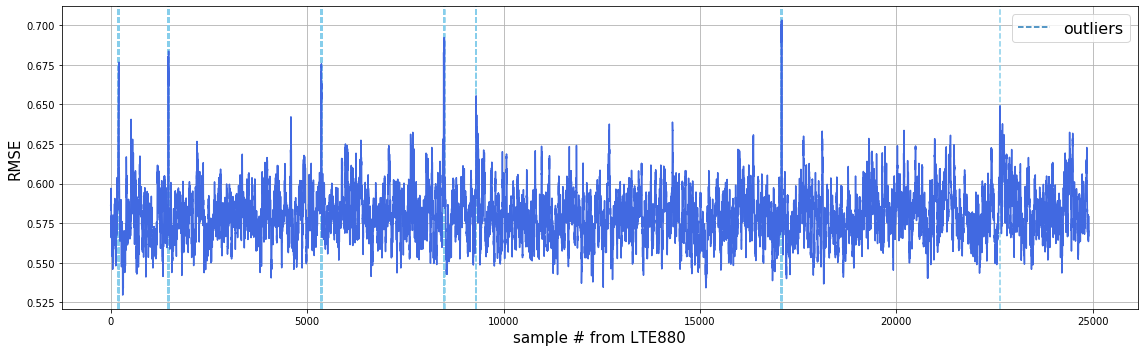

In [21]:
plot_outliers(LTE880_errors, LTE880_outliers, 'LTE880')

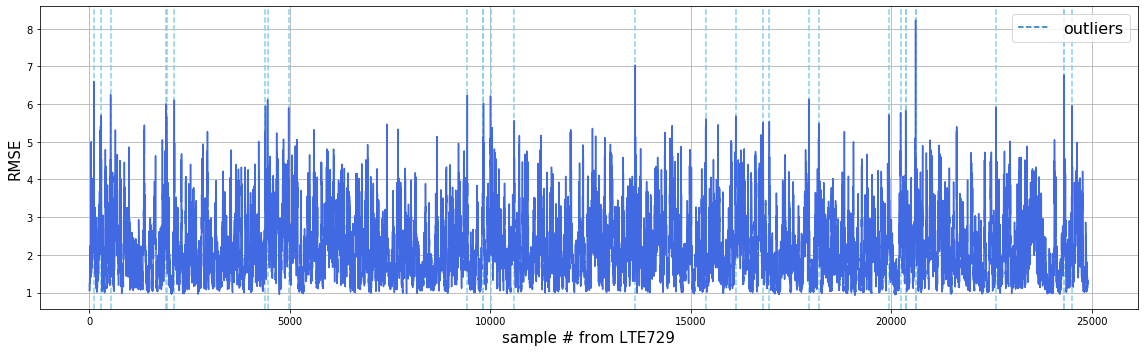

In [22]:
plot_outliers(LTE729_errors, LTE729_outliers, 'LTE729')

In [23]:
LTE880_outliers

array([  193,   194,   195,   196,   197,   198,   199,   200,   201,
         202,   203,   204,   205,   206,   207,   208,   209,   210,
         211,  1455,  1456,  1457,  1458,  1459,  1460,  1461,  1462,
        1463,  1464,  1465,  1466,  1467,  1468,  1469,  1470,  1471,
        1472,  1473,  1474,  1475,  1476,  1477,  1478,  1479,  5349,
        5350,  5351,  5352,  5353,  5354,  5355,  5356,  5357,  5358,
        5359,  5360,  5361,  5362,  5363,  5364,  5365,  5366,  5367,
        5368,  5369,  5370,  5371,  5372,  5373,  8474,  8475,  8476,
        8477,  8478,  8479,  8480,  8481,  8482,  8483,  8484,  8485,
        8486,  8487,  8488,  8489,  8490,  8491,  8492,  8493,  8494,
        8495,  8496,  8497,  8498,  9301,  9302,  9303,  9304,  9305,
       17068, 17069, 17070, 17071, 17072, 17073, 17074, 17075, 17076,
       17077, 17078, 17079, 17080, 17081, 17082, 17083, 17084, 17085,
       17086, 17087, 17088, 17089, 17090, 17091, 17092, 22643])

In [40]:
np.where(LTE729_errors == np.max(LTE729_errors))

(array([20606]),)

In [25]:
np.where(LTE880_errors == np.max(LTE880_errors))

(array([17085]),)

In [27]:
LTE880[17085], 

(array([[-1.1704319 , -1.29243524, -1.3410382 , ..., -1.23371493,
         -1.66598369, -1.10714886],
        [-1.92705101, -1.39440226, -1.11508404, ..., -1.38706223,
         -1.18669901, -1.06608432],
        [-1.52453916, -1.33032571, -1.43427653, ..., -1.06985353,
         -1.27081189, -0.98990663],
        ...,
        [-1.47395241, -2.17542204, -1.39003792, ..., -1.23292142,
         -1.59912983, -2.42657039],
        [-2.67692522, -2.29068049, -1.73938408, ..., -1.63741705,
         -1.56937291, -2.07444692],
        [-0.99288232, -1.88122536, -1.30691694, ..., -1.25791722,
         -1.76021392, -1.42078673]]),)

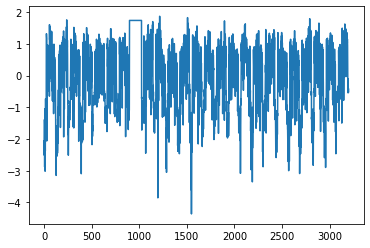

In [29]:
plt.plot(LTE880_Y[17085])

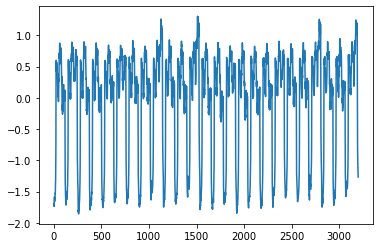

In [34]:
plt.plot(LTE880_predictions[17085].flatten())

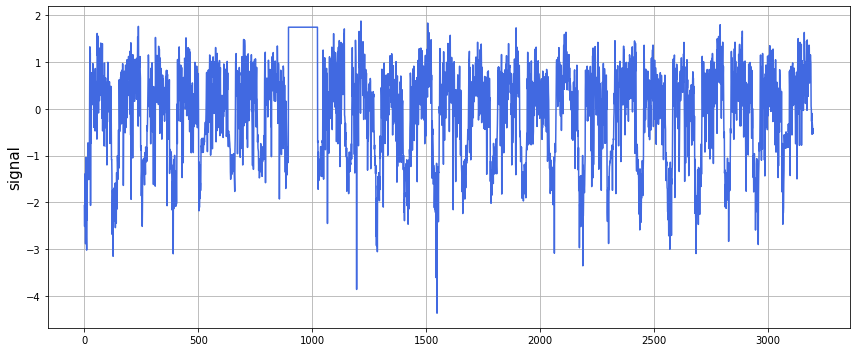

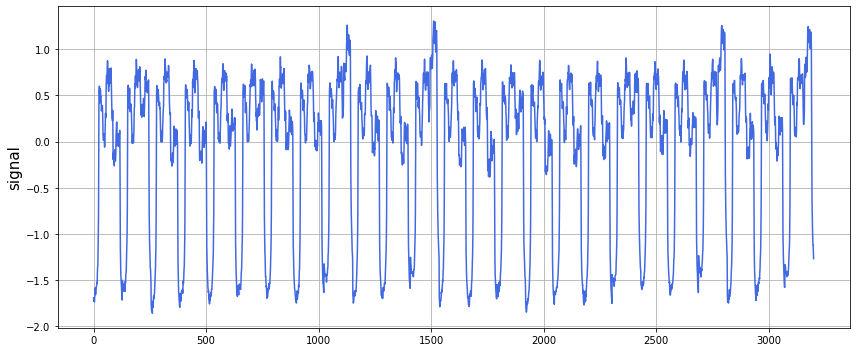

In [39]:
fig, ax = plt.subplots(figsize = (12, 5))

ax.set_ylabel('signal', fontsize = 15)
# ax.set_xlabel('sample # from ' + title, fontsize = 15)
plt.plot(LTE880_Y[17085], color = 'royalblue')
plt.grid()
# plt.legend(fontsize = 16, loc = 'upper right')
plt.tight_layout()
# plt.savefig(title + '.png', dpi = 125)

fig, ax = plt.subplots(figsize = (12, 5))

ax.set_ylabel('signal', fontsize = 15)
# ax.set_xlabel('sample # from ' + title, fontsize = 15)
plt.plot(LTE880_predictions[17085], color = 'royalblue')
plt.grid()
# plt.legend(fontsize = 16, loc = 'upper right')
plt.tight_layout()
# plt.savefig(title + '.png', dpi = 125)

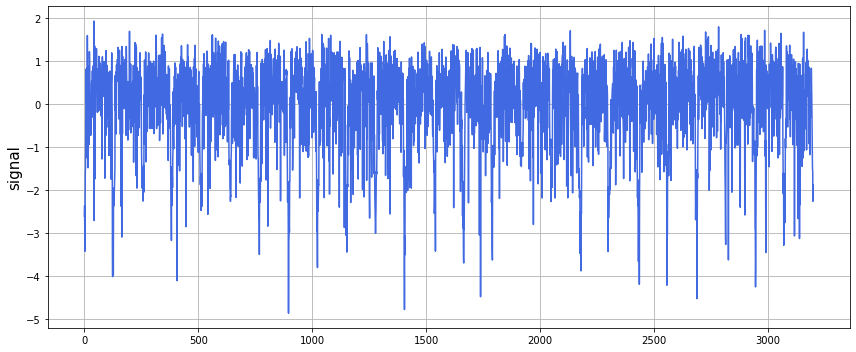

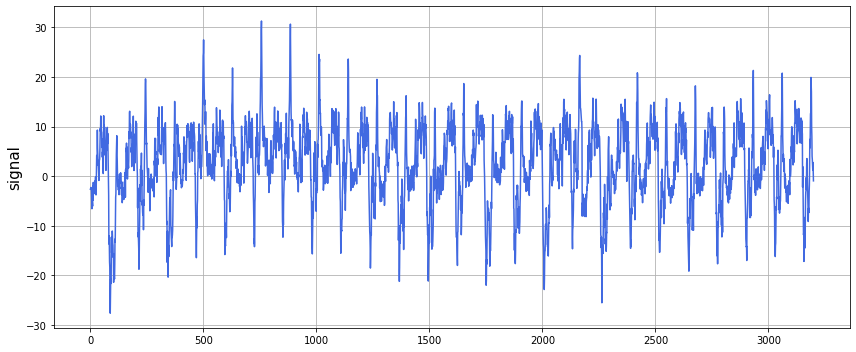

In [41]:
fig, ax = plt.subplots(figsize = (12, 5))

ax.set_ylabel('signal', fontsize = 15)
# ax.set_xlabel('sample # from ' + title, fontsize = 15)
plt.plot(LTE729_Y[20606], color = 'royalblue')
plt.grid()
# plt.legend(fontsize = 16, loc = 'upper right')
plt.tight_layout()
# plt.savefig(title + '.png', dpi = 125)

fig, ax = plt.subplots(figsize = (12, 5))

ax.set_ylabel('signal', fontsize = 15)
# ax.set_xlabel('sample # from ' + title, fontsize = 15)
plt.plot(LTE729_predictions[20606], color = 'royalblue')
plt.grid()
# plt.legend(fontsize = 16, loc = 'upper right')
plt.tight_layout()
# plt.savefig(title + '.png', dpi = 125)